In [1]:
import pandas as pd
import sqlite3
import numpy as np
import json

def load_data_from_db(dbs, tbl):
    sc = list()
    for i, node in enumerate(dbs):
        conn = sqlite3.connect(node)
        
        query_cmd = f'SELECT *, strftime("%Y-%m-%d %H:%M:%S",timestamp) FROM {tbl} WHERE id IN ( SELECT MAX(id) FROM dbstatus GROUP BY timestamp);'

        df = pd.read_sql_query(query_cmd, conn)
        # df.drop('id', axis=1, inplace=True)
        # df.drop('totalblocks', axis=1, inplace=True)
        # df.drop('totaltransactions', axis=1, inplace=True)
        # df.drop('blocks', axis=1, inplace=True)
        # df = df.rename(columns={'ts': 'timestamp'})
        
        # df.astype({'headers': 'int', 'transactions': 'int', 'size': 'int', 'totalquery': 'int', 
        #           'queryfrom': 'int', 'queryto': 'int', 'totaldelay': 'int'}).dtypes

        # #df['totalhop'] = df['totalhop'].apply(json.loads)
        sc.append(df)        
        conn.close()
    return sc

In [2]:
#calculate centrality
import math
import numpy as np

def entropynorm(values):
    vs = np.array(values)
    num = vs.size
    tt = np.sum(vs)
    vs = vs/tt

    npi = np.sum(vs*np.log2(vs, out=np.zeros_like(vs), where=(vs!=0)))
    dpi = math.log2(num)
    return - npi/dpi

def fairnessnorm(values):
    vs = np.array(values)
    num = vs.size

    npi = np.sum(vs)
    npi = npi**2
    dpi = np.square(vs).sum()
    dpi = dpi*num
    
    fn = (npi/dpi - 1/num) / (1 - 1/num)
    
    return fn

values_list = [
                [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
                [0.17, 0.17, 0.13, 0.12, 0.11, 0.09, 0.07, 0.06, 0.05, 0.03],
                [0.42, 0.2, 0.14, 0.07, 0.04, 0.04, 0.03, 0.03, 0.02, 0.01]
                ]

print(entropynorm(values_list[2]))
print(fairnessnorm(values_list[1]))

0.7556018366014379
0.8056472313898059


In [3]:
import os

#PATH = "../blockchainnode/db_nodes"
PATH = "/Users/jwheo/Projects/bcsos/PoS_20221130_083413"
fdbs = [os.path.join(PATH, f) for f in os.listdir(PATH) if f.split(".")[-1] == 'db']
fdbs.sort()
print(fdbs)

['/Users/jwheo/Projects/bcsos/PoS_20221130_083413/7031.db', '/Users/jwheo/Projects/bcsos/PoS_20221130_083413/7032.db', '/Users/jwheo/Projects/bcsos/PoS_20221130_083413/7033.db', '/Users/jwheo/Projects/bcsos/PoS_20221130_083413/7034.db', '/Users/jwheo/Projects/bcsos/PoS_20221130_083413/7035.db', '/Users/jwheo/Projects/bcsos/PoS_20221130_083413/7036.db', '/Users/jwheo/Projects/bcsos/PoS_20221130_083413/7037.db', '/Users/jwheo/Projects/bcsos/PoS_20221130_083413/7038.db']


[54, 52, 49, 47, 55, 34, 32, 42] 365
[48, 38, 49, 33, 47, 43, 51, 53] 362
Fairness Proof 0.9637271269924331
Fairness Verification 0.9777325511792171
Entropy Proof 0.9917722531245293
Entropy Verification 0.9950188216065742


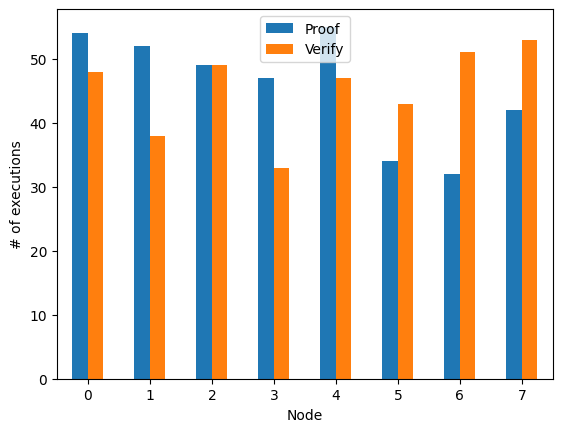

In [4]:
# Count chart for proof and verify
from matplotlib import pyplot as plt
    
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df.shape[0])
print(proof, sum(proof))

dfs = load_data_from_db(fdbs, 'veriftbl')
verif = []
for i, df in enumerate(dfs):
    verif.append(df.shape[0])
print(verif, sum(verif))

ch_list = [proof, verif]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof', 'Verify']
ax = bdf.plot.bar(rot=0)
plt.xlabel("Node")
plt.ylabel("# of executions")
plt.savefig('Num_Prover_Verifier.png', dpi=300, bbox_inches='tight')

print('Fairness Proof', fairnessnorm(proof))
print('Fairness Verification', fairnessnorm(verif))

print('Entropy Proof', entropynorm(proof))
print('Entropy Verification', entropynorm(verif))




Avg Proof[msec] 5.369707538434269
Avg Verif Fwd[msec] 7217.436093417125
Avg Verif Back[msec] 667.5725862710237


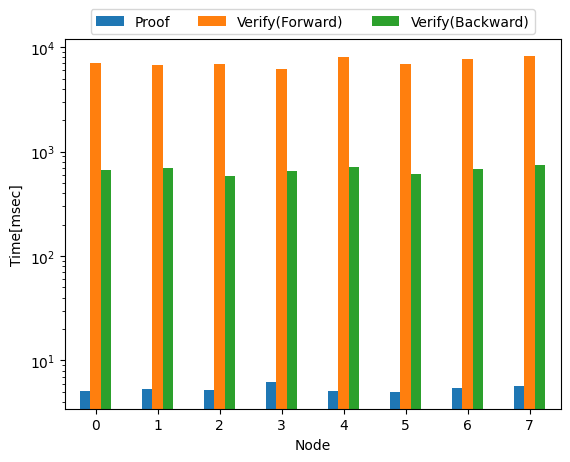

In [5]:
# Avg. Time chart for proof and verify
from matplotlib import pyplot as plt

unit = 1000000 #msec
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df['timegenproof'].mean()/unit)
# print(proof)

dfs = load_data_from_db(fdbs, 'veriftbl')
veriffwd = []
verifrev = []
for i, df in enumerate(dfs):
    veriffwd.append(df['timeveriffwd'].mean()/unit)
    verifrev.append(df['timeverifrev'].mean()/unit)
# print(veriffwd)
# print(verifrev)

ch_list = [proof, veriffwd, verifrev]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof', 'Verify(Forward)', 'Verify(Backward)']
ax = bdf.plot.bar(rot=0)
plt.xlabel("Node")
plt.ylabel("Time[msec]")
# plt.legend(loc='right')
ax.set_yscale('log')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=True, shadow=False, ncol=5)

plt.savefig('Avg_Time_Proof_Verify.png', dpi=300, bbox_inches='tight')

print('Avg Proof[msec]', sum(proof)/len(proof))
print('Avg Verif Fwd[msec]', sum(veriffwd)/len(veriffwd))
print('Avg Verif Back[msec]', sum(verifrev)/len(verifrev))


[902.6905925925926, 1075.5982307692307, 944.6419591836735, 911.8182978723404, 1003.5002181818181, 900.8895294117647, 995.382, 922.0832380952381]
Avg size of proof 957.0755082633322


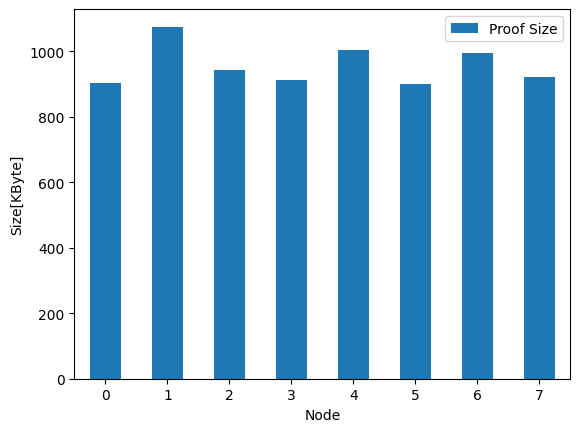

In [6]:
# Avg. Size chart for proof 
from matplotlib import pyplot as plt

unit = 1000 #kbyte
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df['sizegenproof'].mean()/unit)
print(proof)

ch_list = [proof]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof Size']
ax = bdf.plot.bar(rot=0)
plt.xlabel("Node")
plt.ylabel("Size[KByte]")
plt.savefig('Avg_Size_Proof.png', dpi=300, bbox_inches='tight')

print('Avg size of proof', sum(proof)/len(proof))


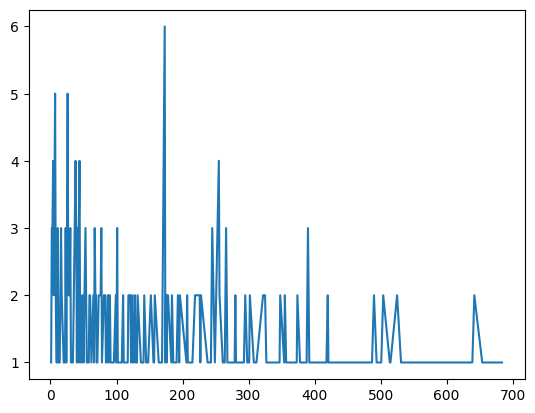

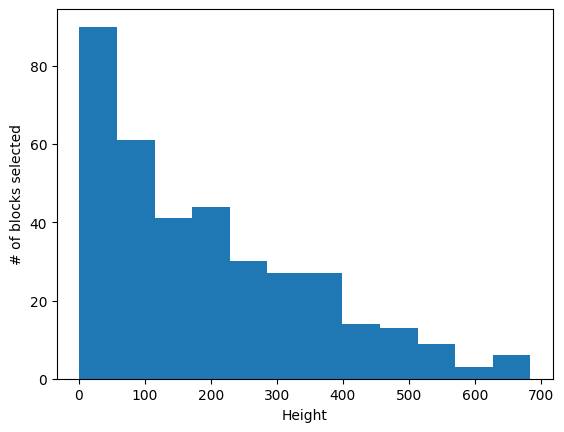

In [7]:
# List up proof block and show it in the time order 
from matplotlib import pyplot as plt

dfs = load_data_from_db(fdbs, 'prooftbl')
hash = []
for i, df in enumerate(dfs):
    for s in df['proofblock']:        
        hash.append(s)
# print(hash)

height = []
for i, df in enumerate(dfs):
    for h in df['proofheight']:        
        height.append(h)
# print(height)

ch_list = [hash, height]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Hash', 'Height']

bdf = bdf.sort_values(by=['Height'])
bdf2 = bdf.groupby(['Height'])['Height'].count().reset_index(name="Count")

plt.plot(bdf2['Height'], bdf2['Count'])

bdf = pd.DataFrame([height]).transpose()
ax = bdf.plot.hist(bins=12, label='Count')
ax.get_legend().remove()

plt.xlabel("Height")
plt.ylabel("# of blocks selected")

plt.savefig('Proof_Blocks.png', dpi=300, bbox_inches='tight')



0.5833592747635363 0.9603692912956338
0.6120031914328297 0.9471170166014274
0.7686206558408547 0.9764528553231996


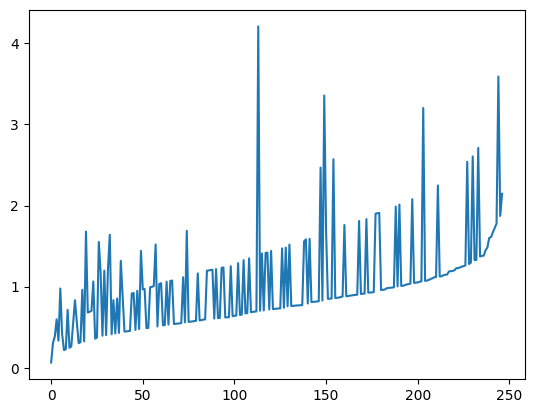

In [8]:
import numpy as np
 
def cal_evenness1(vdf, vmax):
    vdf['weight'] = (vmax - vdf['Height'])
    vdf['norm_cnt'] = vdf['Count']/vdf['weight']
    values = vdf['norm_cnt'].to_list()
    nf = fairnessnorm(values)
    ne = entropynorm(values)
    print(nf, ne)
    
def cal_evenness2(vdf, vmax):
    vdf['norm_cnt'] = vdf['Count']*vdf['Height']
    values = vdf['norm_cnt'].to_list()
    nf = fairnessnorm(values)
    ne = entropynorm(values)
    print(nf, ne)

def cal_acc_prob(vmax):
    pis = []
    for i in range(vmax):
        pi = 0
        for j in range(max(i, 5), vmax):
            pi += 1/(j-1)
        # pi = pi*np.log10(pi)
        pis.append(pi)
    
    mpis = max(pis)
    # https://en.wikipedia.org/wiki/Entropy_(information_theory)
    pis2 = [x /mpis for x in pis]
    pis2[:] = [-np.log10(x) for x in pis2] 
    # print(pis2)
    # plt.plot(pis2)
    return pis, pis2

def cal_evenness3(sdf, vmax):
    vdf = sdf.copy()
    pis, pis2 = cal_acc_prob(vmax)

    # vdf.set_index('Height', inplace=True)
    # vdf = vdf.reindex(list(range(0,vmax)),fill_value=0)    
    # vdf['weight'] =  pis
    vdf['weight'] = [pis2[v] for v in vdf['Height'].values]
    vdf['Count2'] = [pis[v] for v in vdf['Height'].values]
    # print('weights',vdf)
    vdf['norm_cnt'] = vdf['Count']*vdf['weight']
    # vdf['norm_cnt'] = vdf['Count2']*vdf['weight']
    values = vdf['norm_cnt'].to_list()
    
    nf = fairnessnorm(values)
    ne = entropynorm(values)
    print(nf, ne)
    # print(values)
    plt.plot(values)
    
    # print(vdf['norm_cnt'])
    
    # vdf['norm_cnt'].plot()
    
cal_evenness1(bdf2, 720)
cal_evenness2(bdf2, 720)
cal_evenness3(bdf2, 720)



In [9]:
def cal_acc_prob(vmax):
    pis = []
    for i in range(vmax):
        pi = 0
        for j in range(i, vmax):
            pi += 1/(j+1)
        pis.append(pi*np.log10(i+1))
    # print(pis)
    
    return pis
pis = cal_acc_prob(720)
# plt.plot(pis)
bdf = pd.DataFrame([pis]).transpose()
bdf.columns = ['Count']
# ax = bdf.plot.hist(bins=12, label='Count')
bdf2

,Height,Count,weight,norm_cnt
0,1,1,719,1
1,2,3,718,6
2,3,3,717,9
3,4,4,716,16
4,5,2,715,10
...,...,...,...,...
242,629,1,91,629
243,639,1,81,639
244,642,2,78,1284
245,654,1,66,654
